# [DRAFT] Computing WO with S2 ARD and New Fmask Input <img align="right" src="../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with `DEA Sandbox` environments
* **Prerequisites:** Users of this notebook should complete
    * [DEA Water Observations](DEA_Water_Observations.ipynb) for context of Water Observations
    * [Computing WO from S2](Computing_WO_from_S2_ARD.ipynb) to see how WO can be applied to Sentinel 2 ARD. 
    **Users should follow this notebook to install a local copy of WO to apply to S2 ARD.**

## Background
Upon investigation, some errors from the `Fmask` layer have been propagated through to the Water Observations (Sentinel 2, Provisional) output. 
Some new `Fmask` layers have been generated for this notebook using different parameters, and can be accessed in `Supplementary_Data/Computing_WO_from_S2_ARD/Fmask`. 
We cannot conclude they are improvements until the Water Observation Feature Layer (WOFL) has been generated to evaluate the final output.

To create a WOFL with Fmask, we can combine them with the S2 ARD bands required for `woffles_ard()`. 
In this notebook, we will load an Fmask geotiff and combine it with a S2 ARD granule as an `xarray.Dataset` for further analysis. 

For more information on the `xarray` and `rioxarray` functions used:

* [rioxarray.open_rasterio](https://corteva.github.io/rioxarray/html/rioxarray.html#rioxarray-open-rasterio)
* [xarray.open_dataset](http://xarray.pydata.org/en/stable/generated/xarray.open_dataset.html)
* [xarray.open_mfdataset](http://xarray.pydata.org/en/stable/generated/xarray.open_mfdataset.html)

## Description
This notebook shows how to open raster data from file using `xarray`'s built-in fuctions for handling GeoTIFF and NetCDF files, and merging the raster data with S2 ARD. 
It then demonstrates how WO can be applied to the new dataset to visualise the differences from changing the Fmask parameters.

1. Opening single GEOTIFF raster files (the new Fmask output)
    * Convert to xarray.Dataset
2. Find corresponding S2 ARD from datacube.
    * Convert to xarray.Dataset
3. Combine the two arrays to get one full dataset. 
    * Ensure they have the same spatial reference
4. Apply WO and evaluate the output
***

## Getting started
 To run this example, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages

In [1]:
# Let python know to plot figures after the cells they are called in
%matplotlib inline

# Import general packages and tools
import numpy as np
import xarray as xr
import rioxarray
import datacube
import rasterio.crs
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
from datacube.utils.geometry import Geometry, CRS 
from datacube.utils.cog import write_cog
from datetime import datetime, timedelta

# Import DEA tools
import sys
sys.path.insert(1, '../Tools/')
from dea_tools.datahandling import paths_to_datetimeindex, load_ard
from dea_tools.bandindices import calculate_indices
from dea_tools.plotting import rgb, plot_wo
from dea_tools.temporal import time_buffer
from dea_tools.spatial import xr_rasterize
from dea_tools.dask import create_local_dask_cluster

# Local copy of WOfS - input bands have been adjusted according to README.rst
# Update file path as needed
sys.path.insert(1, "../S2_WO_Quality_Testing/wofs-1.6.5/")
from wofs.wofls import woffles_ard

## Opening a Single Raster File
We need to open the raster of interest to confirm it is the correct raster and to join it to the S2 ARD later in this notebook.

### Define file paths
In the code below we define the locations of the GeoTIFF files that we will open. 
These were created when testing fmask parameters on S2 imagery. 
The fmask output is a classified layer with 6 classes: `null`, `clear`, `cloud`, `shadow`, `snow`, and `water`. 
To open a different tile, edit the geotiff name to the corresponding file and update the date according to the table below when loading S2 ARD.
Red-Green-Blue image thumbnails have been attached for reference.

|Tile ID| General Area | Date | Issue Explored/Features Present | Filename | Thumbnail |
| --- | --- | --- | --- | --- | --- |
| 54HTG | Adelaide | 2023/04/24 | False Positive Buildings | 54HTG_newparam.tif |[Thumbnail 54HTG](https://data.dea.ga.gov.au/baseline/ga_s2bm_ard_3/54/HTG/2023/04/24/20230424T021111/ga_s2bm_nbar_3-2-1_54HTG_2023-04-24_final_thumbnail.jpg) |
| 56JNQ | Gold Coast | 2023/10/08 | Urban Area, Clouds, Bright Beach, Ocean | 56JNQ_newparam.tif |[Thumbnail 56JNQ](https://data.dea.ga.gov.au/baseline/ga_s2bm_ard_3/56/JNQ/2023/04/05/20230406T004909/ga_s2bm_nbart_3-2-1_56JNQ_2023-04-05_final_thumbnail.jpg) |
| 56HLH | Sydney | 2023/04/09 | False Positive Buildings| 56HLH_newparam.tif |[Thumbnail 56HLH](https://data.dea.ga.gov.au/baseline/ga_s2bm_ard_3/56/HLH/2023/04/09/20230409T005903/ga_s2bm_nbar_3-2-1_56HLH_2023-04-09_final_thumbnail.jpg) |
| 50HLK | Perth | 2023/04/26 | Severe Underestimate | 50HLK_newparam.tif |[Thumbnail 50HLK](https://data.dea.ga.gov.au/baseline/ga_s2am_ard_3/50/HLK/2023/04/26/20230426T052534/ga_s2am_nbart_3-2-1_50HLK_2023-04-26_final_thumbnail.jpg) |
| 52JEL | Nullarbor NP | 2023/05/06 | Severe Underestimate | 52JEL_newparam.tif |[Thumbnail 52JEL](https://data.dea.ga.gov.au/baseline/ga_s2bm_ard_3/52/JEL/2023/05/06/20230506T025255/ga_s2bm_nbar_3-2-1_52JEL_2023-05-06_final_thumbnail.jpg) |
| 54HVH | Renmark | 2023/05/06 | Severe Underestimate | 54HVH_newparam.tif |[Thumbnail 54HVH](https://data.dea.ga.gov.au/baseline/ga_s2am_ard_3/54/HVH/2023/05/06/20230506T032513/ga_s2am_nbart_3-2-1_54HVH_2023-05-06_final_thumbnail.jpg) |
| 54HXK | Lake Menindee | 2023/08/21 | Cloud and Shadow over Water | 54HXK_newparam.tif |[Thumbnail 54HXK](https://data.dea.ga.gov.au/baseline/ga_s2am_ard_3/54/HXK/2023/08/21/20230821T014837/ga_s2am_nbar_3-2-1_54HXK_2023-08-21_final_thumbnail.jpg) |
| 51JUF | Lake Lefroy | 2023/06/29 | Cloud and Shadow over Salt Lake | 51JUF_newparam.tif |[Thumbnail 51JUF](https://data.dea.ga.gov.au/baseline/ga_s2am_ard_3/51/JUF/2023/06/29/20230629T050615/ga_s2am_nbar_3-2-1_51JUF_2023-06-29_final_thumbnail.jpg) |
| 50HMG | Lake Muir | 2023/09/05 | Cloud, Cloud Shadow, Water, Steep Terrain, Thick Forest| 50HMG_newparam.tif |[Thumbnail 50HMG](https://data.dea.ga.gov.au/baseline/ga_s2bm_ard_3/50/HMG/2023/09/05/20230905T052006/ga_s2bm_nbar_3-2-1_50HMG_2023-09-05_final_thumbnail.jpg) |
| 56HLJ | Cessnock | 2023/07/28 | Altocumulus Clouds, Beach, Ocean | 56HLJ_newparam.tif |[Thumbnail 56HLJ](https://data.dea.ga.gov.au/baseline/ga_s2bm_ard_3/56/HLJ/2023/07/28/20230728T005606/ga_s2bm_nbar_3-2-1_56HLJ_2023-07-28_final_thumbnail.jpg) |
| 51JWL | Yeo Lake Nature Reserve | 2023/07/06 | Cirrus Clouds, Salt Lake | 51JWL_newparam.tif |[Thumbnail 51JWL](https://data.dea.ga.gov.au/baseline/ga_s2am_ard_3/51/JWL/2023/07/06/20230706T040332/ga_s2am_nbar_3-2-1_51JWL_2023-07-06_final_thumbnail.jpg) |
| 53HME | Pureba Conservation Park | 2023/07/06 | Cumulus Clouds, Cloud Shadows | 53HME_newparam.tif |[Thumbnail 53HME](https://data.dea.ga.gov.au/baseline/ga_s2bm_ard_3/53/HME/2023/07/06/20230706T022413/ga_s2bm_nbar_3-2-1_53HME_2023-07-06_final_thumbnail.jpg) |


In [2]:
sys.path.insert(1, '../dev/dea-notebooks/')
# Update file path and name as needed
geotiff_path = '../Supplementary_data/Computing_WO_from_S2_ARD/Fmask/54HXK_newparam.tif'
# Set Time of Interest - refer to table of tiles
time_of_interest = '2023-08-21'

# Set filenames for exporting later (optional)
# Update name for new wofl
# newwofloutputname = '../Supplementary_data/Computing_WO_from_S2_ARD/WO_outputs/54HXK_new_wofl.tif'
# Update name for default wofl
# defaultwofloutputname = '../Supplementary_data/Computing_WO_from_S2_ARD/WO_outputs/54HXK_default_wofl.tif'

### Open the new Fmask layer
To open a geotiff we use `rioxarray.open_rasterio()` function which is built around the `rasterio` Python package.
When dealing with extremely large rasters, this function can be used to load data as a Dask array by providing a `chunks` parameter (e.g. `chunks={'x': 1000, 'y': 1000}`). This can be useful to reduce memory usage by only loading the specific portion of the raster you are interested in.

In [3]:
# Open into an xarray.DataArray
geotiff_da = rioxarray.open_rasterio(geotiff_path)

# Covert our xarray.DataArray into a xarray.Dataset
geotiff_dss = geotiff_da.to_dataset('band')

# Rename the variable to a more useful name
geotiff_ds = geotiff_dss.rename({1: 'fmask'})

# Check array
geotiff_ds.spatial_ref

<xarray.DataArray 'spatial_ref' ()>
array(0)
Coordinates:
    spatial_ref  int64 0
Attributes: (12/18)
    crs_wkt:                           PROJCS["WGS 84 / UTM zone 54S",GEOGCS[...
    semi_major_axis:                   6378137.0
    semi_minor_axis:                   6356752.314245179
    inverse_flattening:                298.257223563
    reference_ellipsoid_name:          WGS 84
    longitude_of_prime_meridian:       0.0
    ...                                ...
    longitude_of_central_meridian:     141.0
    false_easting:                     500000.0
    false_northing:                    10000000.0
    scale_factor_at_central_meridian:  0.9996
    spatial_ref:                       PROJCS["WGS 84 / UTM zone 54S",GEOGCS[...
    GeoTransform:                      598920.0 20.0 0.0 6501680.0 0.0 -20.0

This new fmask layer is already georeferenced, so it will be easier to find the corresponding S2 ARD. 

We can check what the new fmask layer looks like by plotting it. 

|Fmask Value | Class |
| --- | --- |
| 0 | Null |
| 1 | Clear |
| 2 | Cloud |
| 3 | Shadow |
| 4 | Snow |
| 5 | Water |

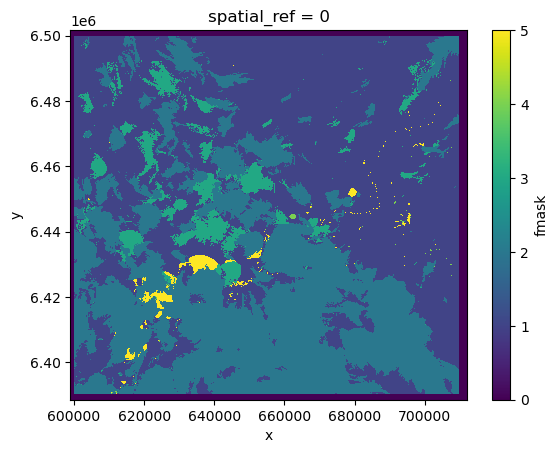

In [4]:
# Check image ouptut
geotiff_ds.fmask.plot()

### Assign Attributes
While we know what the Fmask numbers represent from the metadata, this isn't explicitly defined in the dataset yet. 
To set this, we can assign attributes to the Fmask layer.

In [5]:
# Check the format of xarray
geotiff_ds.info

# Assign attributes to the fmask layer
geotiff_ds['fmask'].attrs = {'nodata': 0,
                             'bits': [0, 1, 2, 3, 4, 5, 6, 7], 
                             'values': {'0': 'nodata', '1': 'valid', '2': 'cloud', '3': 'shadow', '4': 'snow', '5': 'water'}, 
                             'description': 'Fmask'}
# Check whether the attributes have been assigned correctly
geotiff_ds

<xarray.Dataset>
Dimensions:      (y: 5659, x: 5658)
Coordinates:
  * x            (x) float64 5.989e+05 5.99e+05 5.99e+05 ... 7.12e+05 7.121e+05
  * y            (y) float64 6.502e+06 6.502e+06 ... 6.389e+06 6.389e+06
    spatial_ref  int64 0
Data variables:
    fmask        (y, x) uint8 ...
Attributes:
    AREA_OR_POINT:       Area
    DataType:            Thematic
    RepresentationType:  THEMATIC
    _FillValue:          0
    scale_factor:        1.0
    add_offset:          0.0

## Load Corresponding Sentinel 2 ARD
To see how the new Fmask layer influences the WO output, we'll need to plot both the default and new outputs and visualise the differences. 
This involves loading in the S2 ARD that spans the same study area defined by the new Fmask layer. 
The bands required are listed in `measurementsdefault`.

In [6]:
# Connect to the Datacube
dc = datacube.Datacube(app='Cloud_Masking_fromfmask')

# Set up dask
client = create_local_dask_cluster(return_client=True)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/yukie.nip@ga.gov.au/proxy/8787/status,
Dashboard: /user/yukie.nip@ga.gov.au/proxy/8787/status,Workers: 1
Total threads: 2,Total memory: 12.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36439,Workers: 1
Dashboard: /user/yukie.nip@ga.gov.au/proxy/8787/status,Total threads: 2
Started: Just now,Total memory: 12.21 GiB
Comm: tcp://127.0.0.1:32981,Total threads: 2
Dashboard: /user/yukie.nip@ga.gov.au/proxy/35483/status,Memory: 12.21 GiB
Nanny: tcp://127.0.0.1:39301,


### Fixed Parameters
When loading in data, it is convenient to separate fixed parameters that will not need updating from the dynamic variables that can be changed for testing. 
* `products` : A list of product names to load from the datacube e.g. `["ga_s2am_ard_3", "ga_s2bm_ard_3"]`
* `measurements` : A list of band names to load from the satellite product e.g. `["nbart_coastal_aerosol", "nbart_blue", "nbart_green", "nbart_red", "nbart_nir_1", "nbart_nir_2", "nbart_swir_2", "nbart_swir_3", "oa_fmask"]`
* `resolution` : The spatial resolution of the loaded satellite data e.g. for Sentinel 2, this is `(-10, 10)`
* `output_crs` : The coordinate reference system/map projection to load data into, e.g. `'EPSG:3577'` to load data in the Albers Equal Area projection. If using vector file inputs, we will adopt the CRS of those files.
* `align` : How to align the x, y coordinates respect to each pixel. Sentinel 2 Collection 3 should be centre aligned `align = (5, 5)` if data is loaded in its native UTM zone projection, e.g. `'EPSG:32756'`
* `maturity`: Maturity of a dataset is dictated by the quality of the ancillary information used to generate the product. The maturity levels are Near Real Time (NRT), Interim, and Final. The final ARD should be of highest quality.

In [7]:
# Fixed parameters
products = ["ga_s2am_ard_3", "ga_s2bm_ard_3"]
# WO doesn't need red edge, not concerned about vegetation.
measurements = ["nbart_coastal_aerosol", "nbart_blue", "nbart_green", "nbart_red", "nbart_nir_1", "nbart_nir_2", "nbart_swir_2", "nbart_swir_3", "oa_fmask"]
resolution = (-10, 10) 
output_crs = "EPSG:3577"
align = (5, 5) 
maturity = "final" 
ticks = [0,1,2,3,4,5]
labels = ['No Data', 'Clear', 'Cloud', 'Shadow', 'Snow', 'Water']

### Dynamic Parameters
* `time_of_interest`: Enter a time, in units YYYY-MM-DD, around which to load satellite data e.g. `'2019-01-01'`.
This is the date for the new Fmask layer, and should have been set when the new layer was loaded in.
* `time_buff` : A buffer of a given duration (e.g. days) around the time_of_interest parameter, e.g. `'3 days'`. 
For testing, we already know where and when to look, so the buffer can be reduced to 1 day to speed up processing time.

In [8]:
# Dynamic Parameters
# For testing purposes, this is 1 day because we know what date to inspect.
time_buff = '1 days'

### Define Query
Defining a query makes it easier to re-use parameters when loading new S2 ARD.

In [9]:
# Find matching datasets    
query = {'time': time_buffer(time_of_interest, buffer=time_buff),
         'measurements': measurements,
         'like': geotiff_ds.geobox,
         'group_by': 'solar_day',
         'dask_chunks':{}
         }                              

In [10]:
# Load Sentinel 2
dsdefault = dc.load(product=("ga_s2am_ard_3","ga_s2bm_ard_3"),
        dataset_maturity="final",
        **query)

# Copy the oa_fmask variable and name it fmask
dsdefault['fmask'] = dsdefault['oa_fmask']

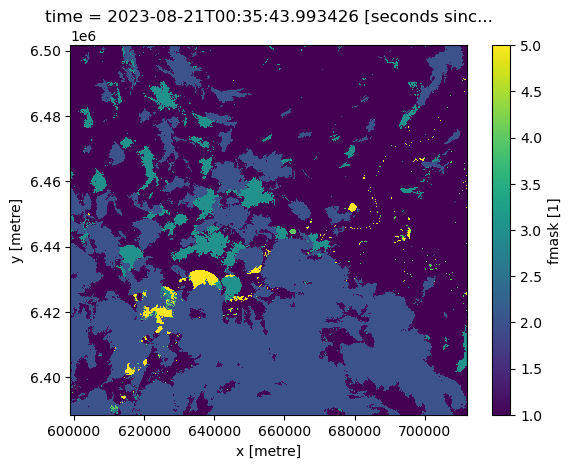

In [11]:
# Compare default S2 Fmask layer
dsdefault.fmask.isel(time=0).plot()

In [12]:
# inspect the structure of the original S2 dataset.
dsdefault.isel(time=0)

<xarray.Dataset>
Dimensions:                (y: 5659, x: 5658)
Coordinates:
    time                   datetime64[ns] 2023-08-21T00:35:43.993426
  * y                      (y) float64 6.502e+06 6.502e+06 ... 6.389e+06
  * x                      (x) float64 5.989e+05 5.99e+05 ... 7.12e+05 7.121e+05
    spatial_ref            int32 32754
Data variables:
    nbart_coastal_aerosol  (y, x) int16 dask.array<chunksize=(5659, 5658), meta=np.ndarray>
    nbart_blue             (y, x) int16 dask.array<chunksize=(5659, 5658), meta=np.ndarray>
    nbart_green            (y, x) int16 dask.array<chunksize=(5659, 5658), meta=np.ndarray>
    nbart_red              (y, x) int16 dask.array<chunksize=(5659, 5658), meta=np.ndarray>
    nbart_nir_1            (y, x) int16 dask.array<chunksize=(5659, 5658), meta=np.ndarray>
    nbart_nir_2            (y, x) int16 dask.array<chunksize=(5659, 5658), meta=np.ndarray>
    nbart_swir_2           (y, x) int16 dask.array<chunksize=(5659, 5658), meta=np.ndarray>
    nbart_swir_3           (y, x) int16 dask.array<chunksize=(5659, 5658), meta=np.ndarray>
    oa_fmask               (y, x) uint8 dask.array<chunksize=(5659, 5658), meta=np.ndarray>
    fmask                  (y, x) uint8 dask.array<chunksize=(5659, 5658), meta=np.ndarray>
Attributes:
    crs:           PROJCS["WGS 84 / UTM zone 54S",GEOGCS["WGS 84",DATUM["WGS_...
    grid_mapping:  spatial_ref

## Make a Copy fo the S2 Data for Merging
To swap in the new Fmask for comparison, a copy of the ARD is made and the default Fmask is dropped before merging the dataset with the new Fmask as `xarray.Dataset`

In [13]:
dsnew = dsdefault.copy(deep=True)
dsnew

<xarray.Dataset>
Dimensions:                (time: 1, y: 5659, x: 5658)
Coordinates:
  * time                   (time) datetime64[ns] 2023-08-21T00:35:43.993426
  * y                      (y) float64 6.502e+06 6.502e+06 ... 6.389e+06
  * x                      (x) float64 5.989e+05 5.99e+05 ... 7.12e+05 7.121e+05
    spatial_ref            int32 32754
Data variables:
    nbart_coastal_aerosol  (time, y, x) int16 dask.array<chunksize=(1, 5659, 5658), meta=np.ndarray>
    nbart_blue             (time, y, x) int16 dask.array<chunksize=(1, 5659, 5658), meta=np.ndarray>
    nbart_green            (time, y, x) int16 dask.array<chunksize=(1, 5659, 5658), meta=np.ndarray>
    nbart_red              (time, y, x) int16 dask.array<chunksize=(1, 5659, 5658), meta=np.ndarray>
    nbart_nir_1            (time, y, x) int16 dask.array<chunksize=(1, 5659, 5658), meta=np.ndarray>
    nbart_nir_2            (time, y, x) int16 dask.array<chunksize=(1, 5659, 5658), meta=np.ndarray>
    nbart_swir_2           (time, y, x) int16 dask.array<chunksize=(1, 5659, 5658), meta=np.ndarray>
    nbart_swir_3           (time, y, x) int16 dask.array<chunksize=(1, 5659, 5658), meta=np.ndarray>
    oa_fmask               (time, y, x) uint8 dask.array<chunksize=(1, 5659, 5658), meta=np.ndarray>
    fmask                  (time, y, x) uint8 dask.array<chunksize=(1, 5659, 5658), meta=np.ndarray>
Attributes:
    crs:           PROJCS["WGS 84 / UTM zone 54S",GEOGCS["WGS 84",DATUM["WGS_...
    grid_mapping:  spatial_ref

In [14]:
# Remove default fmask
dsnew = dsnew.drop_vars('oa_fmask')
dsnew = dsnew.drop_vars('fmask')

In [15]:
# Check
dsnew

<xarray.Dataset>
Dimensions:                (time: 1, y: 5659, x: 5658)
Coordinates:
  * time                   (time) datetime64[ns] 2023-08-21T00:35:43.993426
  * y                      (y) float64 6.502e+06 6.502e+06 ... 6.389e+06
  * x                      (x) float64 5.989e+05 5.99e+05 ... 7.12e+05 7.121e+05
    spatial_ref            int32 32754
Data variables:
    nbart_coastal_aerosol  (time, y, x) int16 dask.array<chunksize=(1, 5659, 5658), meta=np.ndarray>
    nbart_blue             (time, y, x) int16 dask.array<chunksize=(1, 5659, 5658), meta=np.ndarray>
    nbart_green            (time, y, x) int16 dask.array<chunksize=(1, 5659, 5658), meta=np.ndarray>
    nbart_red              (time, y, x) int16 dask.array<chunksize=(1, 5659, 5658), meta=np.ndarray>
    nbart_nir_1            (time, y, x) int16 dask.array<chunksize=(1, 5659, 5658), meta=np.ndarray>
    nbart_nir_2            (time, y, x) int16 dask.array<chunksize=(1, 5659, 5658), meta=np.ndarray>
    nbart_swir_2           (time, y, x) int16 dask.array<chunksize=(1, 5659, 5658), meta=np.ndarray>
    nbart_swir_3           (time, y, x) int16 dask.array<chunksize=(1, 5659, 5658), meta=np.ndarray>
Attributes:
    crs:           PROJCS["WGS 84 / UTM zone 54S",GEOGCS["WGS 84",DATUM["WGS_...
    grid_mapping:  spatial_ref

## Combine into Single xarray.Dataset
It is difficult to perform raster analyses across separate datasets, so it can be usefull to load multiple files into a single `xarray.Dataset`.
This also allows us to analyse data in a format that is directly compatible with data directly loaded from the Datacube.

<b>This current method is for testing 1 timestep at a time to reduce dimension complications. </b>

To reduce the dataset to one timestep, you can:
   * drop the time dimension entirely -> ard.drop("time")
   * take the first timestep ds.isel(time=0)
   * or set time dimension for fmask and make it equal to ARD time, so the arrays will only merge if the timesteps match.


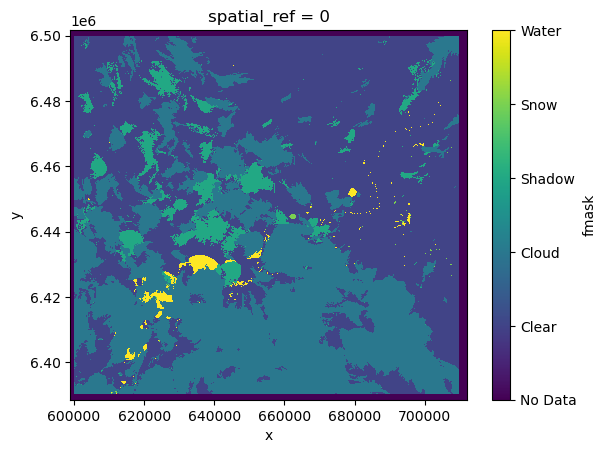

In [16]:
# check this is the new fmask we want to merge
newfmask = geotiff_ds.fmask.plot()
cbar = newfmask.colorbar
cbar.set_ticks(ticks)
cbar.set_ticklabels(labels)
plt.show()

In [17]:
# since the new fmask layer only exists in one timestep, we'll reduce the ARD to one timestep as well so they can be merged.
ard = dsnew.isel(time=0)
datasets=[ard,geotiff_ds]

In [18]:
# Combine the two datasets into one xarray.Dataset
combined = xr.merge(datasets, join='outer', compat = 'override')

# Check dataset
combined

<xarray.Dataset>
Dimensions:                (y: 5659, x: 5658)
Coordinates:
    time                   datetime64[ns] 2023-08-21T00:35:43.993426
  * y                      (y) float64 6.502e+06 6.502e+06 ... 6.389e+06
  * x                      (x) float64 5.989e+05 5.99e+05 ... 7.12e+05 7.121e+05
    spatial_ref            int32 32754
Data variables:
    nbart_coastal_aerosol  (y, x) int16 dask.array<chunksize=(5659, 5658), meta=np.ndarray>
    nbart_blue             (y, x) int16 dask.array<chunksize=(5659, 5658), meta=np.ndarray>
    nbart_green            (y, x) int16 dask.array<chunksize=(5659, 5658), meta=np.ndarray>
    nbart_red              (y, x) int16 dask.array<chunksize=(5659, 5658), meta=np.ndarray>
    nbart_nir_1            (y, x) int16 dask.array<chunksize=(5659, 5658), meta=np.ndarray>
    nbart_nir_2            (y, x) int16 dask.array<chunksize=(5659, 5658), meta=np.ndarray>
    nbart_swir_2           (y, x) int16 dask.array<chunksize=(5659, 5658), meta=np.ndarray>
    nbart_swir_3           (y, x) int16 dask.array<chunksize=(5659, 5658), meta=np.ndarray>
    fmask                  (y, x) uint8 ...
Attributes:
    crs:           PROJCS["WGS 84 / UTM zone 54S",GEOGCS["WGS 84",DATUM["WGS_...
    grid_mapping:  spatial_ref

To verify the data was loaded correctly, we can plot it using `xarray`:

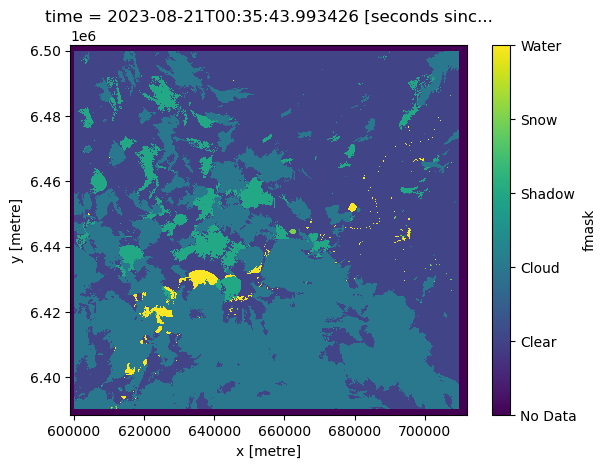

In [19]:
# plot the new fmask layer to see if it exists in the combined dataset.
combinedfig = combined.fmask.plot()
cbar = combinedfig.colorbar
cbar.set_ticks(ticks)
cbar.set_ticklabels(labels)
plt.show()

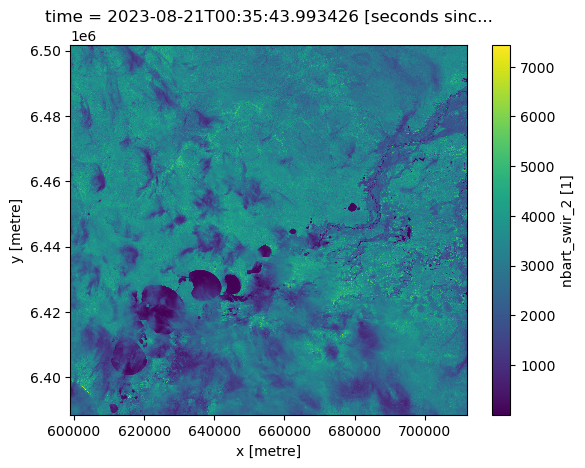

In [20]:
# plot an nbart band to check for any errors from the merge
combined.nbart_swir_2.plot()

## Compute WO
Now our two datasets are ready. We have one set of S2 ARD with the default Fmask layer `dsdefault`, and another with the new fmask layer swapped in `combined`.

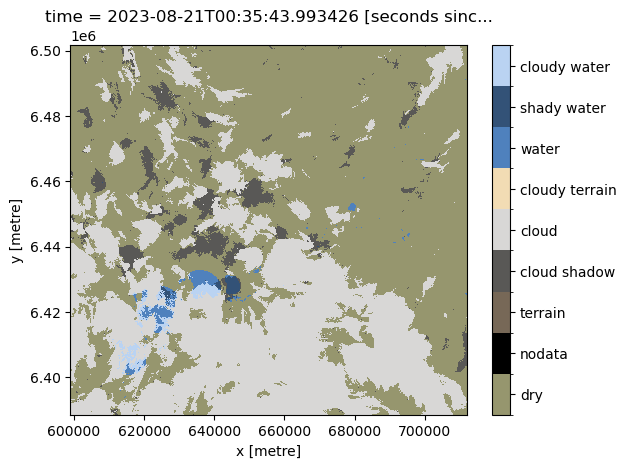

In [21]:
# Apply woffles ard
defaultwofls = woffles_ard(dsdefault.isel(time=0), dsm=None)
# Plot woffles ard output
plot_wo(defaultwofls)

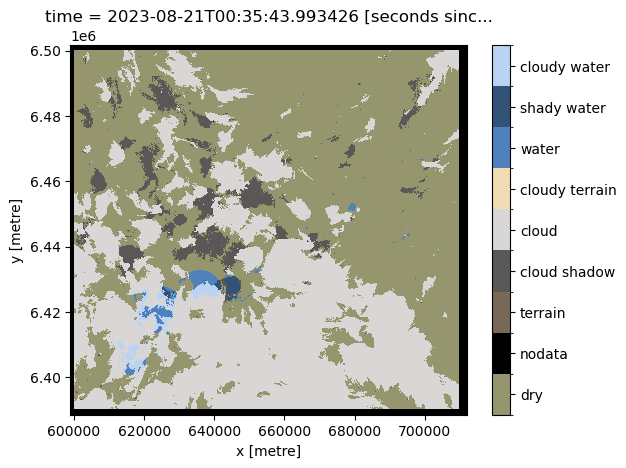

In [22]:
# Apply woffles ard
newwofls = woffles_ard(combined, dsm=None)
# plot woffles ard output
plot_wo(newwofls)

## Comparing Outputs
The WO algorithm output is a classification with the bit meanings described in the [Water Observations Product Page](https://docs.dea.ga.gov.au/data/product/dea-water-observations-sentinel-2-nrt/). 
Since classes and combinations of classes have unique values, it is possible to determine which class a pixel changed from by subtracting `new wofl` from `default wofl`. 
For example, a decimal value of -64 would mean a dry pixel (0) in `default wofl` has been changed to a cloud pixel (64) in `new wofl`, or water became cloud. 
This can be discerned through the difference plot, and concluded from context. 
If the class has not been changed, then the difference between the default and new layer is equal to 0. 

The following matrix provides an example of some changes between classes. 
Note a pixel can be in more than one class eg. shady water (160 = 32 + 128) and there are many more combinations than the ones shown here. 
The default wofls decimal values are presented horizontally, and new wofls are vertical. 
The matrix is populated with the decimal value resulting from the new value subtracted from the default value.

For simplicity, we will be generating a change raster to illustrate the spatial distribution of change. 

|New \ Default |Class | 0 | 1 | 2 | 4 | 8 | 16 | 32 | 64 | 128 | 160 | 192|
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | ---| --- |
| 0 | Dry or Terrain | 0 | 1 | 2 | 4 | 8 | 16 | 32 | 64 | 128 | 160 | 192 | 
| 1 | Null |-1 | 0 | 1 | 3 | 7 | 15 | 31 | 63 | 127 | 159 | 191 | 
| 2 | Contiguity Error | -2 | -1 | 0 | 2 | 6 | 14 | 30 | 62 | 126 | 158 | 190 | 
| 4 | Solar Incidence > 10 | -4 | -3 | -2 | 0 | 4 | 12 | 28 | 60 | 124 | 156 | 188 | 
| 8 | Terrain Shadow |-8 | -7 | -6 | -4 | 0 | 8 | 24 | 56 | 120 | 152 | 184 | 
| 16 | High Slope | -16 | -15 | -14 | -12 | -8 | 0 | 16 | 48 | 112 | 144 | 176 | 
| 32 | Cloud Shadow |-32 | -31 | -30 | -28 | -24 | -16 | 0 | 32 | 96 | 128 | 160 | 
| 64 | Cloud | -64 | -63| -62 | -60 | -56 | -48 | -32 | 0 | 64 | 96 | 128 | 
| 128 | Water | -128 | -127 | -126 | -124 | -120 | -112 | -96 | -64 | 0 | 32 | 64 | 
| 160 | Shady Water | -160 | -159 | -158 | -156 | -152 | -144 | -128 | -96 | -32 | 0 | 32 | 
| 192 | Cloudy Water | -192 | -191 | -190 | -188 | -184 | -176 | -160 | -128 | -64 | -32 | 0 | 


In [23]:
from matplotlib import colors as mcolours
def plot_diff(wo, legend=True, **plot_kwargs):
    """Plot a water observation bit flag image.
    
    Parameters
    ----------
    wo : xr.DataArray
        A DataArray containing water observation bit flags.
    legend : bool
        Whether to plot a legend. Default True.
    plot_kwargs : dict
        Keyword arguments passed on to DataArray.plot.
    
    Returns
    -------
    plot    
    """
    cmap = mcolours.ListedColormap([
        np.array([150, 150, 110]) / 255,  # no change - 0
        np.array([51, 82, 119]) / 255,  # change detected - 1
    ])
    bounds = [
        0,
        1,
    ]

    cblabels = [
        'No Change','Change Detected',
    ]
    
    try:
        im = wo.plot.imshow(cmap=cmap,
    #                        norm=norm,
                            add_colorbar=legend,
                            **plot_kwargs)
    except AttributeError:
        im = wo.plot(cmap=cmap,
             #        norm=norm, 
                     add_colorbar=legend, 
                     **plot_kwargs)
    if legend:
        try:
            cb = im.colorbar
        except AttributeError:
            cb = im.cbar
        cb.set_ticks([0,1])
        cb.set_ticklabels(cblabels)
    return im

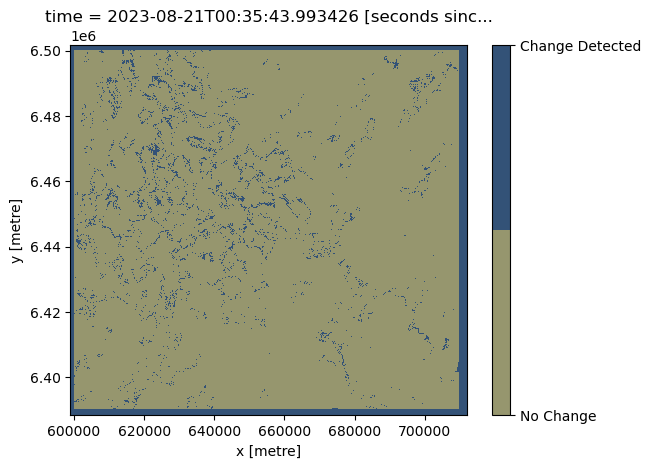

In [24]:
# Calculate the difference between the two rasters
diff = defaultwofls-newwofls

# Generalise values to either no change (0) or change (1)
diff0 = diff.where(diff==0, 1)

# Plot the change raster, defined by cell above
plot_diff(diff0)

### Quantifying Differences Statistically
We can also quantify the differences between the two outputs by summarising the pixel counts for each class. 
With these values we can calculate the percent change. 
The amount of change and direction is dependent on the tile and type of artefact issue being addressed.

In [25]:
unique, counts = np.unique(newwofls, return_counts=True)
newcount= dict(zip(unique, counts))
newcount

{0: 16819309,
 1: 1878522,
 32: 1527192,
 64: 11237984,
 128: 220023,
 160: 74961,
 162: 4,
 192: 260627}

In [26]:
unique, counts = np.unique(defaultwofls, return_counts=True)
defaultcount = dict(zip(unique, counts))
defaultcount

{0: 18811178,
 32: 1361915,
 64: 11288828,
 128: 238328,
 160: 79563,
 162: 4,
 192: 238806}

In [27]:
# print counts for new and default WO for comparison. 
import pandas as pd
pd.DataFrame({'Default Count':pd.Series(defaultcount), 'New Count':pd.Series(newcount)})

,Default Count,New Count
0,18811178.0,16819309
1,NaN,1878522
32,1361915.0,1527192
64,11288828.0,11237984
128,238328.0,220023
160,79563.0,74961
162,4.0,4
192,238806.0,260627


## Exporting Geotiff
Save your outputs if you want to analyse them with a GIS.
File names were assigned when the new Fmask layer was loaded.

In [ ]:
# export the new wofs to save tifs
# Run `write_cog`
ds_exportnew = write_cog(geo_im=newwofls,
                       fname=newwofloutputname,
                       overwrite=True)

# Print ds_exportnew object
print(ds_exportnew)

In [ ]:
ds_exportnew.compute()

In [ ]:
# export the new wofs to save tifs
# Run `write_cog`
ds_exportdefault = write_cog(geo_im=defaultwofls,
                       fname=defaultwofloutputname,
                       overwrite=True)

# Print ds_exportdefault object
print(ds_exportdefault)

In [ ]:
ds_exportdefault.compute()

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** February 2024

## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)